In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import GridSearchCV
from sklearn.dummy import DummyClassifier, DummyRegressor
import numpy as np
# Preprocessing and pipeline
from sklearn.impute import SimpleImputer
import mglearn
# train test split and cross validation
from sklearn.model_selection import cross_val_score, cross_validate, train_test_split
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.preprocessing import (
    StandardScaler,
)
import altair as alt
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor

In [2]:
grade_df = pd.read_csv('data/additional/gradebook.csv')
discussion_df = pd.read_csv('data/additional/discussions.csv')
discussion_topic_df = pd.read_csv('data/additional/discussion_topics.csv')

discussion_df['id'] = discussion_df['discussion_topic_id']
discussion_combined_df = discussion_df.merge(discussion_topic_df)

grade_df['actor_id'] = grade_df['Student']
df = grade_df.merge(discussion_df)

enrol_df = pd.read_csv('data/additional/enrollments.csv')
enrol_df['Student'] = enrol_df['user_id']
df = df.merge(enrol_df)

num_cols = ['Assignment 1 (c81f04547a95da2a7b88054ef491b7c4)',
       'Assignment 2 (a4dc11e7e79361fc5886a9078aac66b8)',
       'Assignment 3 (option A) (811d93ea379b5cdd5a19f1b5dbab88cd)',
       'Assignment 3 (option B) (df8d1f1ff3f48fdc24a278b40c5f45cc)',
       'Assignment 3 (option C) (bb971b36c1578cede00150acda89aa99)',
       'Assignment 3 (option D) (f1ad954cd2cddda6e17f6fc225d1aa3e)',
       'Participation grade: Formative (not included in final grade) (5965e0b0c712861d0efdd9be54572114)',
       'Assignment 1 Current Score', 'Assignment 2 Current Score',
       'Assignment 3 Current Score',
       'Participation & engagement Current Score', 'Current Score',]

for col in num_cols:
    df[col] = df[col].apply(float)


In [3]:
df_mean = df.groupby('Student').aggregate('mean')
df_sum = df.groupby('Student').aggregate('sum')
df_count = df.groupby('Student').aggregate('count')

canvas_df = pd.concat([df_mean[['Participation & engagement Current Score','Current Score',
                                'count_of_likes','total_activity_time']], 
                       df_sum[['discussion_topic_message_length','post_message_length']],
                      df_count[['last_activity_at']]],axis =1)

canvas_df['answer_count'] =  canvas_df['last_activity_at']
canvas_df = canvas_df.drop(['last_activity_at'],axis = 1)

In [4]:
canvas_df.head()

,Participation & engagement Current Score,Current Score,count_of_likes,total_activity_time,discussion_topic_message_length,post_message_length,answer_count
Student,,,,,,,
LEARNER_1,90.0,80.9,0.214286,985351.0,12207,33617,14
LEARNER_10,85.0,78.4,0.298246,421763.0,48509,60378,57
LEARNER_11,90.0,84.3,0.156250,285214.0,31952,40861,32
LEARNER_12,80.0,81.2,0.200000,176035.0,19072,22838,20
LEARNER_13,80.0,85.5,0.219512,774430.0,36887,44122,41


In [5]:
train_df, test_df = train_test_split(canvas_df, test_size=0.2, random_state=123)

train_df.head()

,Participation & engagement Current Score,Current Score,count_of_likes,total_activity_time,discussion_topic_message_length,post_message_length,answer_count
Student,,,,,,,
LEARNER_16,100.0,82.0,0.196078,586198.0,45110,87921,51
LEARNER_33,40.0,72.1,0.000000,547149.0,9085,7047,9
LEARNER_20,55.0,69.7,0.045455,201541.0,21776,20719,22
LEARNER_2,60.0,84.6,0.290323,152876.0,22443,32704,31
LEARNER_25,90.0,87.3,0.205128,110669.0,34233,25090,39


In [6]:
X_train = train_df.drop(['Current Score'], axis=1)
X_test = test_df.drop(['Current Score'], axis=1)
y_train = train_df['Current Score']
y_test = test_df['Current Score']

In [7]:
dummy = DummyRegressor()
dummy.fit(X_train, y_train)
dummy.score(X_test, y_test)

-0.04886244503632664

In [8]:
pd.DataFrame(dummy.predict(X_test), y_test, columns = ['prediction'])

,prediction
Current Score,
65.7,81.626923
70.9,81.626923
84.4,81.626923
88.0,81.626923
78.3,81.626923
92.2,81.626923
78.5,81.626923


In [27]:
svr = SVR()
scaler = StandardScaler()
pipe = make_pipeline(scaler, svr)
pipe.fit(X_train, y_train)
pipe.score(X_test,y_test)

0.3435526800484907

In [33]:
pd.DataFrame(np.array([pipe.predict(X_test),
             y_test]).T, 
             columns = ['prediction', 'target'])

,prediction,target
0,80.442970,65.7
1,79.547524,70.9
2,81.707317,84.4
3,83.249288,88.0
4,83.732376,78.3
5,82.895178,92.2
6,80.184186,78.5


In [10]:
pipe_svm = make_pipeline(StandardScaler(), SVR())

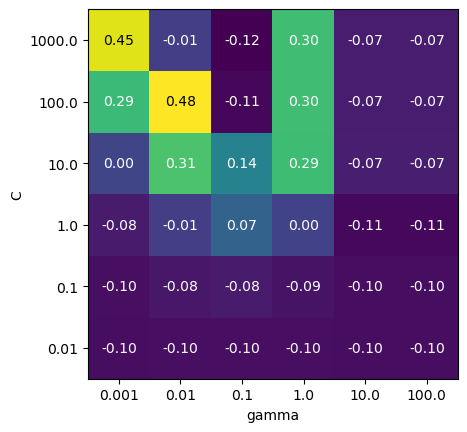

In [11]:
def display_heatmap(param_grid, pipe, X_train, y_train):
    grid_search = GridSearchCV(
        pipe, param_grid, cv=5, n_jobs=-1, return_train_score=True
    )
    grid_search.fit(X_train, y_train)
    results = pd.DataFrame(grid_search.cv_results_)
    scores = np.array(results.mean_test_score).reshape(6, 6)

    # plot the mean cross-validation scores
    mglearn.tools.heatmap(
        scores,
        xlabel="gamma",
        xticklabels=param_grid["svr__gamma"],
        ylabel="C",
        yticklabels=param_grid["svr__C"],
        cmap="viridis",
    );
param_grid1 = {
    "svr__gamma": 10.0**np.arange(-3, 3, 1), 
    "svr__C": 10.0**np.arange(-2, 4, 1)
}
display_heatmap(param_grid1, pipe_svm, X_train, y_train)

In [12]:
grid_search = GridSearchCV(
        pipe_svm, param_grid1, cv=5, n_jobs=-1, return_train_score=True
    )

grid_search.fit(X_train, y_train)
res = pd.DataFrame(grid_search.predict(X_test), y_test, columns = ['prediction']).reset_index()


In [13]:
grid_search.score(X_test, y_test)

0.08691076806512466

In [14]:
x = 10.0**np.arange(-50, 0, 1)
res = []
for i in (x):
    ridge = Ridge(alpha=i)

    pipe = make_pipeline(StandardScaler(), ridge)
    pipe.fit(X_train, y_train)
    res.append(pipe.score(X_train, y_train))

Text(0, 0.5, 'Score')

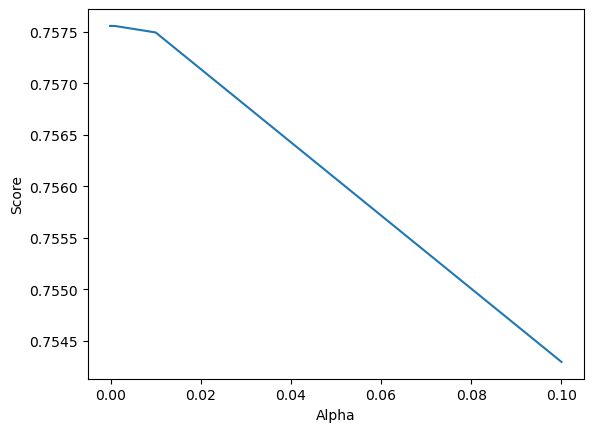

In [35]:
plt.plot(x, res)
plt.xlabel('Alpha')
plt.ylabel('Score')

In [37]:
ridge = Ridge(alpha=1e-50)

pipe = make_pipeline(StandardScaler(), ridge)
pipe.fit(X_train, y_train)

pd.DataFrame(np.array([pipe.predict(X_test),
             y_test]).T, 
             columns = ['prediction', 'target'])

pipe.score(X_train, y_train)

0.7575583513308782

In [17]:
coeffs = pipe['ridge'].coef_
feature_names = X_train.columns
viz_df = pd.DataFrame(coeffs,feature_names).reset_index()
viz_df.columns = ['coefficient', 'importance']
viz_df

,coefficient,importance
0,Participation & engagement Current Score,4.164112
1,count_of_likes,1.325596
2,total_activity_time,0.443990
3,discussion_topic_message_length,-0.700075
4,post_message_length,-2.071634
5,answer_count,1.936124


In [18]:
alt.Chart(viz_df).transform_calculate(
    negative='datum.y < 0'
).mark_bar().encode(
    x='importance',
    y=alt.Y('coefficient', impute={'value': 0}),
)

alt.Chart(...)

In [19]:
splom = train_df[['Participation & engagement Current Score', 'Current Score','answer_count']]

In [39]:
alt.Chart(splom).mark_point(opacity=0.6, size=20).encode(
     alt.X(alt.repeat('row'), type='quantitative', scale=alt.Scale(zero=False)),
     alt.Y(alt.repeat('column'), type='quantitative', scale=alt.Scale(zero=False))
).properties(
    width=200,
    height=200
).repeat(
    column=['Participation & engagement Current Score','Current Score', 'answer_count'],
    row=['Participation & engagement Current Score', 'Current Score','answer_count']
)

alt.RepeatChart(...)